# Prepare Titanic Model for Web / API

Final result on Heroku:
https://titanic-model-app.herokuapp.com/

Sources:
1. https://www.kaggle.com/c/titanic/data

2. https://towardsdatascience.com/create-an-api-to-deploy-machine-learning-models-using-flask-and-heroku-67a011800c50?gi=30b632ffd17d

2. https://blog.cambridgespark.com/deploying-a-machine-learning-model-to-the-web-725688b851c7


In [25]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>
# Align table to left

## Version Control
| Version | Date | Person | Description         
| :- |:------------- | :- | :-
|1.00 |  2/3/2020 | SW| added version control and released to production
|1.01 | 2/6/2020 | SW | added cross validation score 
|1.02 | 2/8/2020 | SW | added hyperparameter tuning for logistic
|1.03 | 2/16/2020 | SW | tested multiple models, including cross validation
|1.04 | 2/26/2020 | SW | ran against test, exported submission, added feature importance and partial dependence to evaluate model
|1.05 | 2/28/2020 | SW | added standard scaler to model and app
|1.06 | 3/14/2020 | SW | updated feature importance graph 

In [26]:
# last updated
from datetime import datetime
print("last updated: " + str(datetime.now()))

last updated: 2020-06-28 11:40:46.192193


## Import modules / libraries and data

In [27]:
import pandas as pd # data manipulation
import seaborn as sns # for data exploration
import numpy as np

from sklearn.preprocessing import StandardScaler # for scaling inputs

from sklearn.linear_model import LogisticRegression # model: logistic regression
from sklearn.svm import SVC # model: SVC / support vector machine
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV # for hyperparameter tuning
from sklearn.model_selection import cross_val_score # for cross validation

from sklearn.inspection import plot_partial_dependence # for model evaluation and understanding
from pdpbox import pdp, get_dataset, info_plots # partial dependence 2 , may need need pip install pdpbox

import json # for exporting data

In [28]:
# create df,
data = pd.read_csv('titanic_train.csv')  # change file path as necessary

## Data exploration, including creating sub-training set

In [29]:
data.shape

(891, 12)

In [30]:
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [31]:
data.describe(include='all') 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Goldschmidt, Mr. George B",male,NaN,NaN,NaN,1601,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [32]:
# see which is na
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [33]:
# drop non-numeric & not relevant data
data = data.drop(['Name','Cabin','Embarked','Ticket'],axis = 1)
data.shape

(891, 8)

In [34]:
# non Numeric data
# one-hot coding 
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore',sparse = False)

nonNumData = data.select_dtypes(exclude = ['int64','float64'])
print(nonNumData.dtypes)

Sex    object
dtype: object


In [35]:
# transformed data is ok because we've removed na's
nonNumDataEncArray = enc.fit_transform(nonNumData) 
nonNumDataEnc = pd.DataFrame(data = nonNumDataEncArray)

In [36]:
print(list(nonNumDataEnc.columns))
featuresNonNumeric = ['Sex-' + str(x) for x in list(nonNumDataEnc.columns)]
print(enc.categories_)
print(featuresNonNumeric)
nonNumDataEnc.columns = featuresNonNumeric

[0, 1]
[array(['female', 'male'], dtype=object)]
['Sex-0', 'Sex-1']


In [37]:
# add new data back to dataset (Sex-0 is 1 for females, Sex-1 is 1 for males)
data = pd.concat([data, nonNumDataEnc], axis=1)

## Feature selection

In [38]:
# features and target
target = ['Survived']
features = ['Pclass', 'Age', 'SibSp', 'Fare'] + featuresNonNumeric # X matrix, y vector

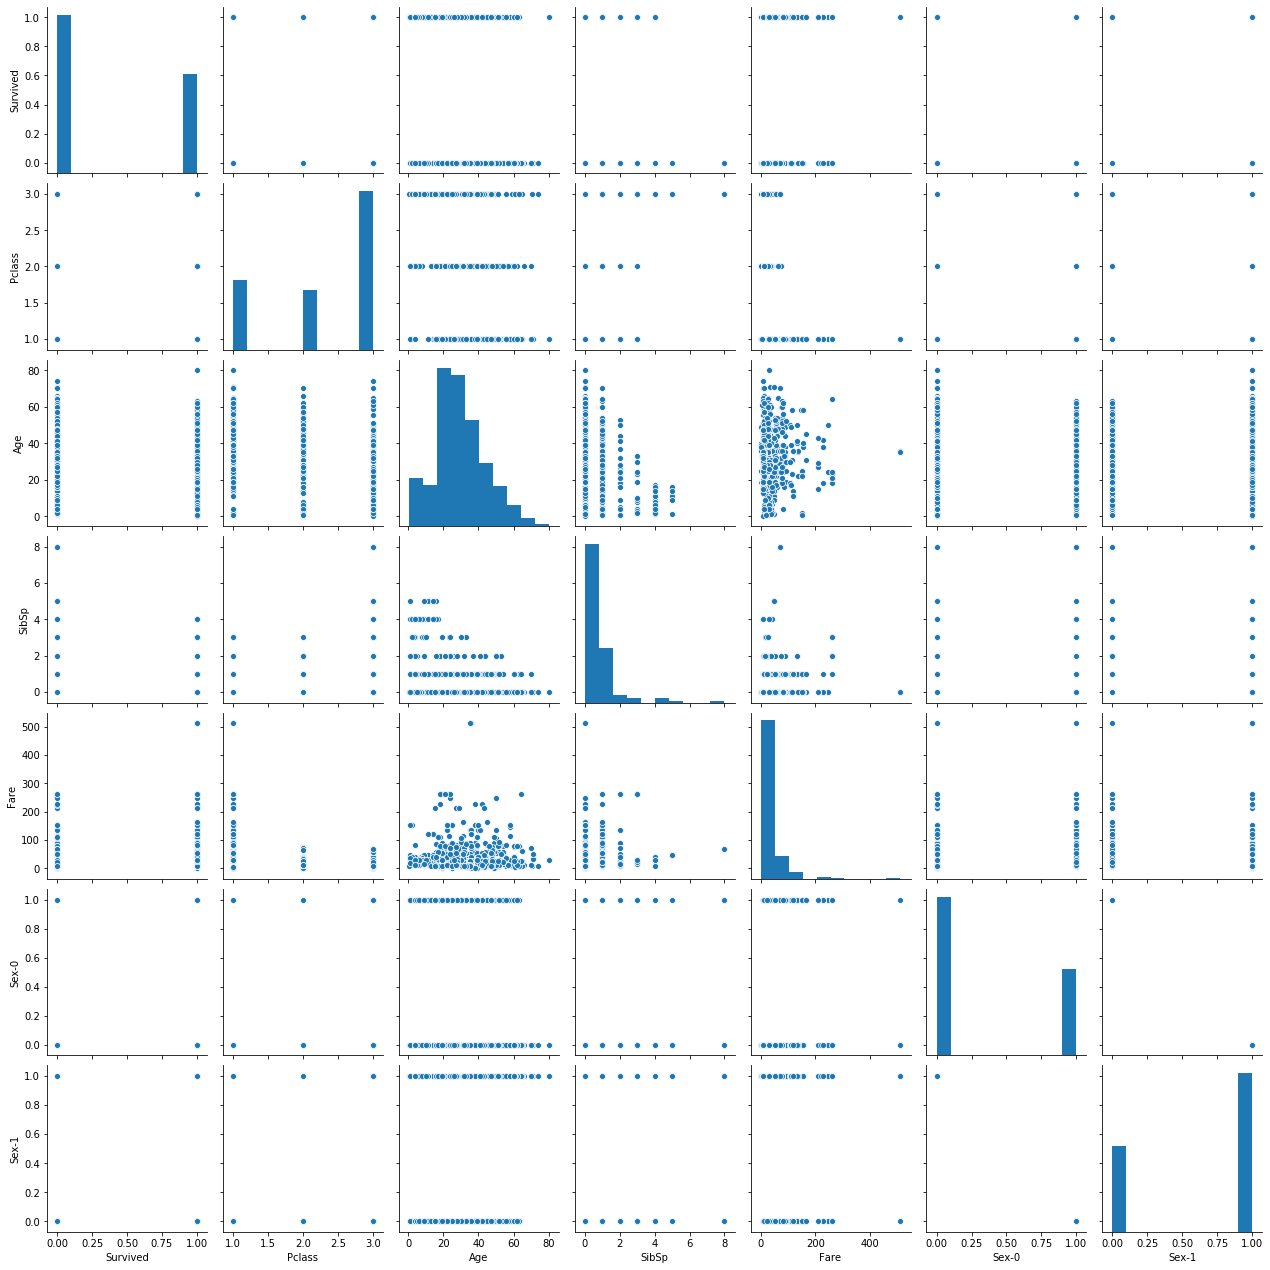

In [39]:
# pairplot
allfeat = target + features
sns.pairplot(data, vars=allfeat)

## Create and train model

In [40]:
# data is encoded with one-hot, ready for analysis
train = data

In [41]:
# drop null values
train.dropna(inplace=True)

In [42]:
# select data set for modeling
X = train[features]
X_orig = X

# scale inputs
scaler = StandardScaler()
X = scaler.fit_transform(X)

y = train[target].values.ravel() # model , covert to 1d array for easy fitting

In [43]:
#creat models for selection
logistic = LogisticRegression(solver='lbfgs',max_iter = 1000)
svc = SVC(gamma='auto')
randforest = RandomForestClassifier(n_estimators=100)
knn = KNeighborsClassifier()
gbc = GradientBoostingClassifier()
# svc = LinearSVC(max_iter = 1000) # doesn't work

In [44]:
model_set = [logistic, svc , randforest, knn, gbc]
model_set_results = {} 

In [45]:
#see which model scores best, using cross validation to remove overfitting
for mdl in model_set:
    scores = cross_val_score(mdl, X, y, cv=5)
    model_set_results[str(mdl)[0:20]] = np.mean(scores)

In [46]:
df = pd.DataFrame(model_set_results.items(), columns=["model", "score"])
print(df)

                  model     score
0  LogisticRegression(C  0.792761
1  SVC(C=1.0, break_tie  0.815178
2  RandomForestClassifi  0.803969
3  KNeighborsClassifier  0.803959
4  GradientBoostingClas  0.826386


Gradient boost is best, accounting for cross validation

In [47]:
# logistic.get_params().keys()

In [48]:
# hyperparameter tuning after model selection
# # Create regularization penalty space
# penalty = ['l2']

# # Create regularization hyperparameter space
# C = [0.1,1,10]

# # Create hyperparameter options
# hyperparameters = dict(C=C, penalty=penalty)

# # Create grid search using 5-fold cross validation
# clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)

In [49]:
#Conduct Grid Search

# # Fit grid search
# best_model = clf.fit(X, y)

# #View Hyperparameter Values Of Best Model

# # View best hyperparameters
# print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
# print('Best C:',  best_model.best_estimator_.get_params()['C'])

In [50]:
# select model
model = gbc
model.fit(X,y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

## Evaluate model

In [51]:
# roc curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y,model.predict(X) ) # roc_curve(actual, expected)
roc_auc = auc(fpr, tpr)


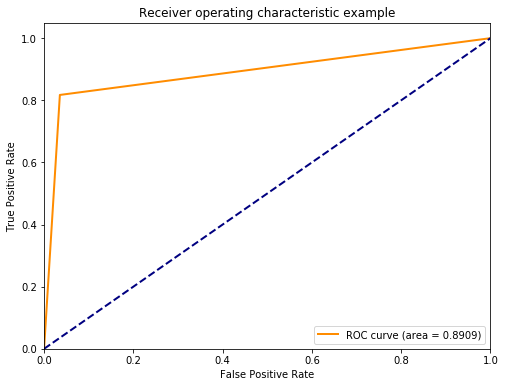

In [52]:
# plot roc curve
import matplotlib.pyplot as plt
plt.figure(figsize = [6.4*1.25, 4.8*1.25])
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

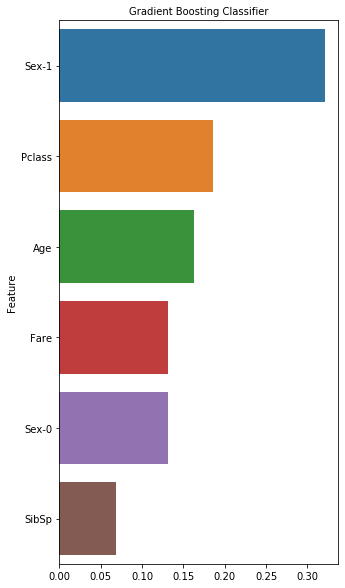

In [53]:
#feature importance
model_importances_table = pd.DataFrame(data = {
    'Feature' : X_orig.columns , 
    'Importance' : model.feature_importances_
})

model_importances_table.sort_values(by='Importance', inplace=True, ascending=False)

plt.figure(figsize=(5, 10))
sns.barplot(x='Importance', y='Feature', data=model_importances_table)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.title('Gradient Boosting Classifier', size=10)

plt.show()
#Sex-0 is female

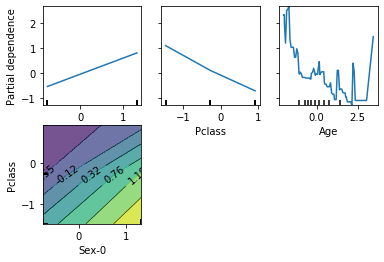

In [54]:
#partial dependence plot 1
pdp_features = ['Sex-0','Pclass','Age' ,('Sex-0','Pclass')] #selected
pdp_feature_names = ['Pclass', 'Age', 'SibSp', 'Fare', 'Sex-0', 'Sex-1'] #based on columns of X, sex-0 is female
plot_partial_dependence(model, X, features=pdp_features, feature_names = pdp_feature_names)

In [55]:
X_df = pd.DataFrame(data = X, columns = X_orig.columns)

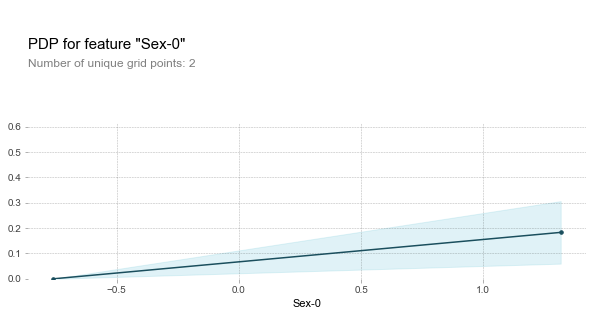

In [56]:
# partial depedence plot detailed, from Kaggle explainability

# Create the data that we will plot
pdp_sex_0 = pdp.pdp_isolate(model=model, dataset=X_df, model_features=pdp_feature_names, feature='Sex-0')

# plot it
pdp.pdp_plot(pdp_sex_0, 'Sex-0', figsize = (10,5))
plt.show()

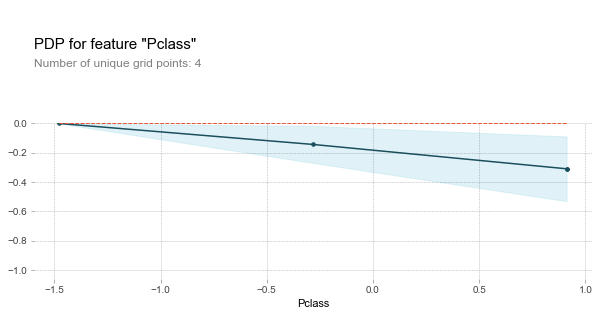

In [57]:
pdp_pclass = pdp.pdp_isolate(model=model, dataset=X_df, model_features=pdp_feature_names, feature='Pclass')

# plot it
pdp.pdp_plot(pdp_pclass, 'Pclass', figsize = (10,5))
plt.show()
#normalized x-axis bc is transformed

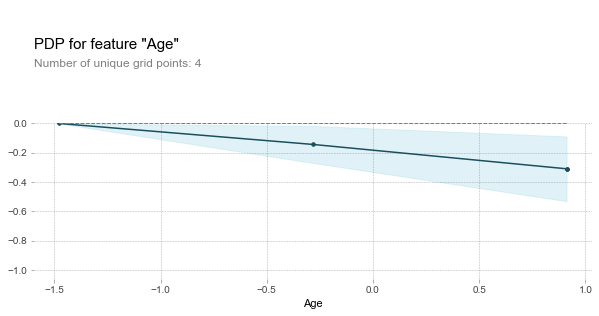

In [58]:
pdp_age = pdp.pdp_isolate(model=model, dataset=X_df, model_features=pdp_feature_names, feature='Age')

# plot it
pdp.pdp_plot(pdp_pclass, 'Age', figsize = (10,5))
plt.show()
#normalized x-axis bc is transformed

## Run Model on Test Data for Kaggle Submission

In [59]:
data_test = pd.read_csv('test.csv')
print(data.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Sex             object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Sex-0          float64
Sex-1          float64
dtype: object


In [60]:
data_test.describe(include='all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Stengel, Mrs. Charles Emil Henry (Annie May Mo...",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


In [61]:
print(featuresNonNumeric)

['Sex-0', 'Sex-1']


In [62]:
#add columns to dictionary 
data_test = data_test.assign(**dict.fromkeys(featuresNonNumeric, 0))

In [63]:
#update NonNumeric columns
data_test.loc[data_test['Sex'] == 'male', 'Sex-1'] = 1  # female 1 or male 1
data_test.loc[data_test['Sex'] == 'female', 'Sex-0'] = 0  # female 1 or male 1


In [64]:
X_predict = data_test[features]   # see feature selection above

#clean up na's
X_predict = X_predict.fillna(X_predict.mean())

#transform for fitting
X_predict = scaler.transform(X_predict)

In [65]:
# result for submission
Y_test = model.predict(X_predict)

In [66]:
# save submission
final_submission = pd.DataFrame({'PassengerID': data_test['PassengerId'], 'Survived': Y_test})

In [67]:
# export submission
final_submission.to_csv('final_submission.csv',index=False, header= True)

## Save model and transformer as pickle

In [68]:
import pickle
pickle.dump(model, open('model.pkl', 'wb'))
pickle.dump(scaler, open('scaler.pkl', 'wb'))

## Run app.py

type "python app.py" in console while in folder

## Test app web interface
Type "flask run" in terminal, once in this directory

## Test app API


In [69]:
# type "flask run" in command line while in parent directory (within anaconda env)

# local url
url = 'http://127.0.0.1:5000' 

In [70]:
# sample data
input_sample = {'Pclass': 3
      , 'Age': 2
      , 'SibSp': 1
      , 'Fare': 50}
input_sample = json.dumps(input_sample)

In [71]:
import requests, json

#send_request = requests.post(url, input_sample)
#print(send_request)

In [72]:
# check actual result
#print(send_request.json())

to stop app, press ctrl+c in console

## Then create Procfile for Heroku app

## Then create requirements.txt

Use:
Flask==1.1.1
gunicorn==19.9.0
pandas==0.25.0
requests==2.22.0
scikit-learn==0.21.2
scipy==1.3.1

More generally, can do:
pip freeze > requirements.txt

## Deploy on Heroku

## Check Heroku

In [73]:
# heroku url
heroku_url = 'https://titanic-model-app.herokuapp.com/' # change to your app name# sample data
input_sample_api = {  'Pclass': 3
             , 'Age': 2
             , 'SibSp': 1
             , 'Fare': 50}
input_sample_api = json.dumps(input_sample_api)

In [74]:
# may need to disable firewall for this
#send_request = requests.post(heroku_url, data)
#print(send_request)

In [75]:
#print(send_request.json())

## Exporting Options
1. From vscode, can export into jupyter notebook using vscode's jupyter interactive window
1. From Jupyter notebook/lab , can export notebook into html
1. From command line, can can convert using nbconvert to html ($ jupyter nbconvert --to FORMAT notebook.ipynb)
